In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
import seaborn as sns

In [2]:
def load_data_from_folders(paths: list[str], experiments: list[str], num_classes: list[int]) -> pd.DataFrame:
    records = []
    for i, path in enumerate(paths):
        exp_name = experiments[i]
        subfolders = sorted([os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])
        for k, sub_path in enumerate(subfolders):
            dataset_name = os.path.basename(sub_path)
            num_c = num_classes[k]
            seed_folders = sorted([os.path.join(sub_path, f) for f in os.listdir(sub_path) if os.path.isdir(os.path.join(sub_path, f))])
            for seed_path in seed_folders:
                seed_folder = os.path.basename(seed_path)
                avg_file = os.path.join(seed_path, 'averages.json')
                if not os.path.exists(avg_file):
                    continue
                with open(avg_file, 'r') as f:
                    avg_data = json.load(f)
                    record = {'experiment': exp_name, "dataset": dataset_name, "classes": num_c, 'seed': seed_folder}
                    record.update(avg_data)
                    records.append(record)
    return pd.DataFrame(records)

In [3]:
path_to_dir = pathlib.Path("~/research/remote_data/").expanduser()
paths = [path_to_dir/"constrained-decoding/6295570ae9286c6be349e46abcde2cbe", path_to_dir/"constrained-decoding-with-cot/499c6cdbf1a5ecbccab59b5e68c8b42b", path_to_dir/"constrained-decoding-no-description/6295570ae9286c6be349e46abcde2cbe", path_to_dir/"unconstrained-decoding/85abdef37c089be430bbffa141f4ed90", path_to_dir/"deepseek-r1-distilled-llama70b/3e01377d7fe0088b4f541bb8e0097d12"]
experiments = ["constrained", "constrained-with-cot", "constrained-no-description", "unconstrained", "deepseek-r1-distilled-llama70b"]
df = load_data_from_folders(paths,experiments, [434, 743, 865, 900])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/amo/research/remote_data/constrained-decoding/6295570ae9286c6be349e46abcde2cbe'

In [5]:
df.head(10)

,experiment,dataset,classes,seed,f1_micro,f1_macro,accuracy,positive_ratio,prediction-bias-ratio
0,constrained,mdace-icd10cm-3.0,434,seed1,0.081867,0.039465,0.008696,3.018092,NaN
1,constrained,mdace-icd10cm-3.0,434,seed2,0.094197,0.043566,0.017391,2.911184,NaN
2,constrained,mdace-icd10cm-3.0,434,seed3,0.093115,0.047561,0.000000,2.320724,NaN
3,constrained,mdace-icd10cm-3.1,743,seed1,0.062377,0.032516,0.008696,3.039872,NaN
4,constrained,mdace-icd10cm-3.1,743,seed2,0.061957,0.031587,0.008696,3.221691,NaN
5,constrained,mdace-icd10cm-3.1,743,seed3,0.060556,0.021540,0.008696,2.845295,NaN
6,constrained,mdace-icd10cm-3.2,865,seed1,0.040208,0.011492,0.008696,3.256735,NaN
7,constrained,mdace-icd10cm-3.2,865,seed2,0.045239,0.015571,0.008696,3.343899,NaN
8,constrained,mdace-icd10cm-3.2,865,seed3,0.053565,0.015514,0.008696,3.378764,NaN
9,constrained,mdace-icd10cm-3.3,900,seed1,0.045767,0.021529,0.008696,3.148734,NaN


In [6]:
def plot_metric_over_classes(ax: plt.Axes, df: pd.DataFrame, metric: str, title: str, text_boxes: list[tuple[int, str]] = [], color: str = "#FF8C00") -> None:
    # Set a color palette for better readability
    palette = sns.color_palette("Set1")
    # Aggregating the data to calculate mean, min, and max for the specified metric
    agg_df = df.groupby(['classes', 'experiment'])[metric].agg(['mean', 'min', 'max']).reset_index()

    # Plotting the line chart with shaded areas
    for i, exp in enumerate(agg_df['experiment'].unique()):
        subset = agg_df[agg_df['experiment'] == exp]
        ax.plot(subset['classes'], subset['mean'], label=exp, marker='o', color=palette[i])
        ax.fill_between(subset['classes'], subset['min'], subset['max'], alpha=0.2, color=palette[i])

    # Add vertical dotted lines and text boxes
    for x, legend in text_boxes:
        # Add vertical dotted line
        ax.axvline(x=x, color=color, linestyle='dotted', linewidth=1.5)

        # Place the text box further below the x-axis
        ax.annotate(
            legend,
            xy=(x, 0),  # x position in data coordinates
            xycoords='data',
            textcoords='offset points',  # Offset below the x-axis
            xytext=(0, -50),  # Position 40 points below the x-axis
            ha='center',
            va='top',
            fontsize=10,
            bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.3')  # Match border color to line
        )

    # Labeling the plot
    ax.set_xlabel('Number of Unique Codes')
    ax.set_ylabel(f'Metric: {metric}')
    ax.set_title(title)
    ax.grid(True)


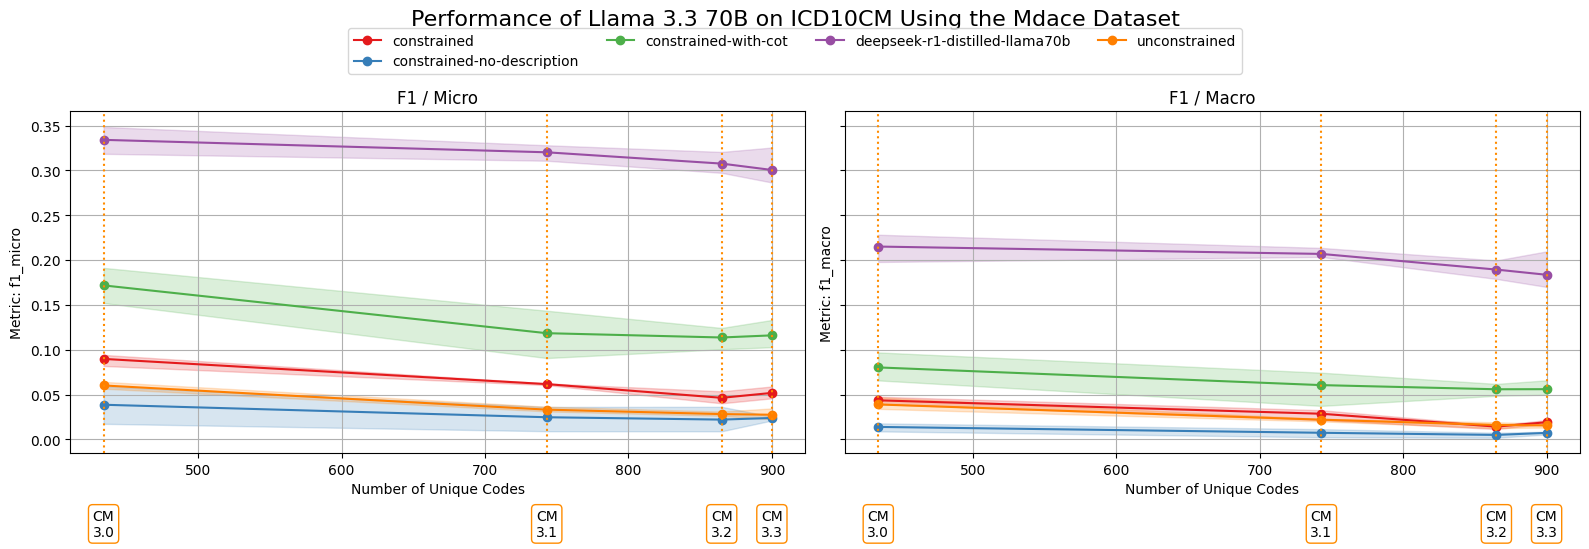

In [7]:
# Create subplots
title = "Performance of Llama 3.3 70B on ICD10CM Using the Mdace Dataset"
subtitle = ["F1 / Micro", "F1 / Macro"]
metrics = ["f1_micro", "f1_macro"]
legends = ["CM\n3.0", "CM\n3.1", "CM\n3.2", "CM\n3.3"]
classes = df['classes'].unique()
text_boxes = list(zip(classes, legends))  # Convert to a list

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# To store handles and labels for the shared legend
handles, labels = [], []

# Plot each metric on a separate subplot
for idx, (ax, metric) in enumerate(zip(axes, metrics)):
    plot_metric_over_classes(ax, df, metric, subtitle[idx], text_boxes=text_boxes)

    # Collect legend elements only for the second subplot
    if idx == 1:  # Skip legend for the first axis
        ax_handles, ax_labels = ax.get_legend_handles_labels()
        handles.extend(ax_handles)
        labels.extend(ax_labels)

# Add the shared legend inside the plot area
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.83), ncol=4, fontsize=10, frameon=True)

# Add the figure title
fig.suptitle(title, fontsize=16, y=0.95)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0.05, 1, 0.9])  # Leave space for the legend and title
plt.show()


In [9]:
def load_data_from_folders(paths: list[str], experiments: list[str], num_classes: list[int]) -> pd.DataFrame:
    records = []
    for i, path in enumerate(paths):
        exp_name = experiments[i]
        subfolders = sorted([os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))])
        for k, sub_path in enumerate(subfolders):
            dataset_name = os.path.basename(sub_path)
            num_c = num_classes[k]
            seed_folders = sorted([os.path.join(sub_path, f) for f in os.listdir(sub_path) if os.path.isdir(os.path.join(sub_path, f))])
            for seed_path in seed_folders:
                seed_folder = os.path.basename(seed_path)
                responses_file = os.path.join(seed_path, 'responses.json')
                if not os.path.exists(responses_file):
                    continue
                with open(responses_file, 'r') as f:
                    responses = json.load(f)
                    record = {'experiment': exp_name, "dataset": dataset_name, "classes": num_c, 'seed': seed_folder}
                    responses = [{**record, **r} for r in responses]
                    records.extend(responses)
    return pd.DataFrame(records)

In [15]:
path_to_dir = pathlib.Path("~/research/remote_data/").expanduser()
paths = [path_to_dir/"constrained-decoding/6295570ae9286c6be349e46abcde2cbe", path_to_dir/"constrained-decoding-with-cot/499c6cdbf1a5ecbccab59b5e68c8b42b", path_to_dir/"constrained-decoding-no-description/6295570ae9286c6be349e46abcde2cbe", path_to_dir/"unconstrained-decoding/85abdef37c089be430bbffa141f4ed90"]
experiments = ["constrained", "constrained-with-cot", "constrained-no-description", "unconstrained"]
df = load_data_from_folders(paths,experiments, [434, 743, 865, 900])

In [25]:
from transformers import AutoTokenizer
from datasets import Dataset

dset = Dataset.from_pandas(df)
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
def tokenize_function(row: dict):
    note = row["segments"][0]
    row["tokens"] = len(tokenizer.encode(note, add_special_tokens=True, truncation=False))
    return row
encoded_dset = dset.map(tokenize_function)

Map:   0%|          | 0/5520 [00:00<?, ? examples/s]

In [26]:
encoded_dset

Dataset({
    features: ['experiment', 'dataset', 'classes', 'seed', 'note_type', 'aid', 'segments', 'targets', 'index2code', 'indexes', 'tokens'],
    num_rows: 5520
})

In [77]:
new_df

""
0
1
2
3
4
...
5515
5516
5517
5518


In [ ]:
import pandas as pd
from agents.base import list2matrix
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

new_df = encoded_dset.to_pandas()
# Assuming your dataset is loaded into a DataFrame `df`, and adjusting for tokens
# new_df['num_tokens_binned'] = pd.qcut(new_df['tokens'], q=50, labels=False)
out = pd.cut(new_df['tokens'], bins=50)
new_df["num_tokens_binned"] = out.apply(lambda x: x.mid)
new_df['preds'] = new_df.apply(lambda x: list2matrix(len(x['segments']), len(x["classes"]), x["indexes"]), axis=1)
new_df['labels'] = new_df.apply(lambda x: list2matrix(len(x['segments']), len(x["classes"]), x["targets"]), axis=1)

# Row-wise F1 computation
def compute_row_f1(row):
    return f1_score(row['labels'], row['preds'], average='micro')

new_df['f1_micro'] = new_df.apply(compute_row_f1, axis=1)

# Group by experiment and token bins
grouped_results = (
    new_df.groupby(['experiment', 'num_tokens_binned'])['f1_micro']
    .mean()
    .reset_index(name='f1_micro')
)

/var/folders/wq/887fx0qd7rj2gpt8w2x8cskh0000gp/T/ipykernel_7924/2059683845.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df.groupby(['experiment', 'num_tokens_binned'])['f1_micro']


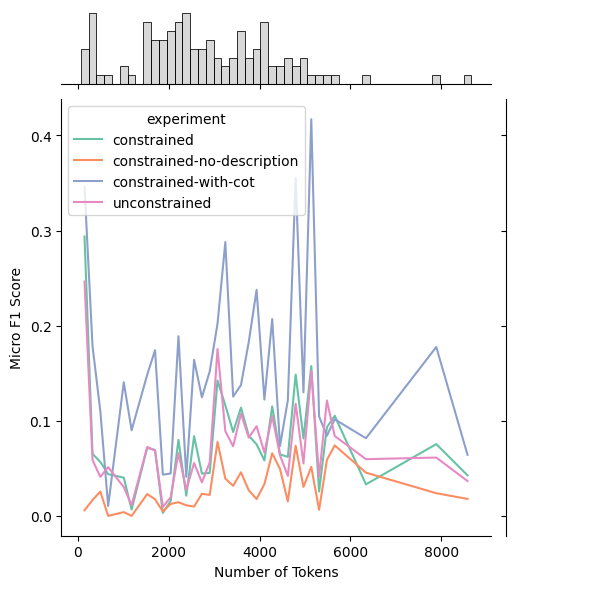

In [92]:
# Re-plotting after removing the unsupported `errorbar` argument
g = sns.JointGrid(
    x='num_tokens_binned',
    y='f1_micro',
    data=grouped_results,
    hue='experiment',
    palette='Set2',
)
g.plot_joint(sns.lineplot, linewidth=1.5)
sns.histplot(
    x='tokens',
    data=new_df,
    ax=g.ax_marg_x,
    bins=50,
    color='gray',
    alpha=0.3,
)
g.set_axis_labels("Number of Tokens", "Micro F1 Score")
sns.move_legend(g.ax_joint, "upper left")

plt.show()

In [97]:
new_grouped_results = (
    new_df.groupby(['experiment', 'note_type'])['f1_micro']
    .mean()
    .reset_index(name='f1_micro')
)
new_grouped_results = new_grouped_results[new_grouped_results["experiment"] != "constrained-no-description"]

/var/folders/wq/887fx0qd7rj2gpt8w2x8cskh0000gp/T/ipykernel_7924/1672909855.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


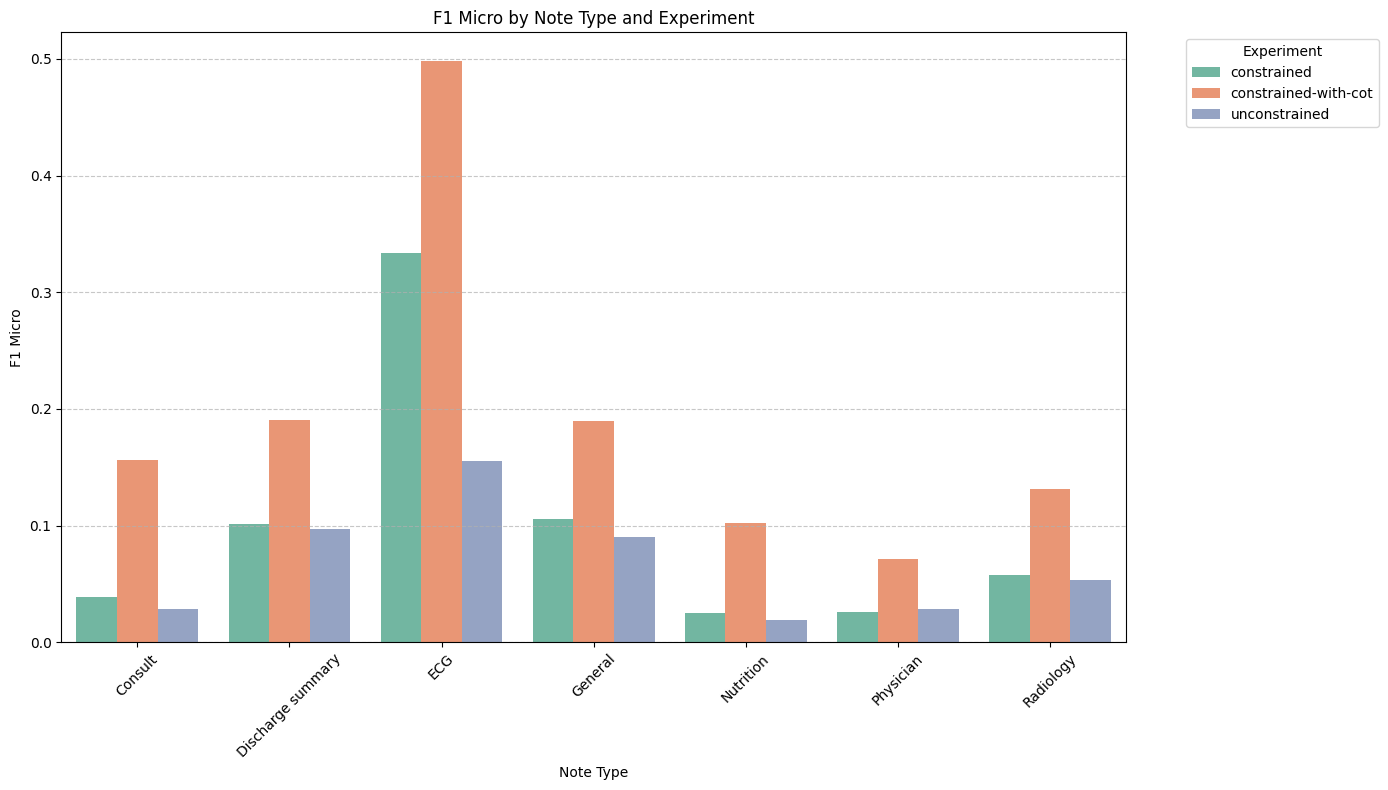

In [101]:
import seaborn as sns

# Alternative: Bar Plot using Seaborn
plt.figure(figsize=(14, 8))
sns.barplot(
    data=new_grouped_results,
    x="note_type",
    y="f1_micro",
    hue="experiment",
    ci=None,
    palette="Set2"
)

plt.title("F1 Micro by Note Type and Experiment")
plt.xlabel("Note Type")
plt.ylabel("F1 Micro")
plt.xticks(rotation=45)
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()